In [1]:
from pyspark.sql import SparkSession

    # build our own SparkSession
spark = (SparkSession
        .builder
        .appName("BigData")
        .config("spark.sql.shuffle.partitions",6)
        .config("spark.sql.repl.eagereval.enabled",True)
        .getOrCreate()
        )

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/04/04 21:42:49 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/04/04 21:42:50 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [16]:
df_hotels = spark.read.parquet('small-hotels')

In [3]:
hotels_count = df_clean.count()
hotels_count

376623

In [17]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import *

from pyspark.ml import Pipeline
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator

import os
import sys

import numpy as np 
import pandas as pd  
import matplotlib.pyplot as plt
import seaborn as sns
# from ydata_profiling import ProfileReport
import warnings
warnings.filterwarnings("ignore")

In [6]:
def plotHistogram(df, xcol, huecol=None):
    sns.histplot(data=df, x=xcol, hue=huecol, multiple="stack")

In [7]:
def plot(df, xcol, ycol):
    sns.lineplot(data=df, x=xcol, y=ycol)

In [8]:
def plotBar(df, xcol, ycol, huecol=None):
    sns.barplot(data=df, x=xcol, y=ycol, hue=huecol)

In [9]:
def plotScatter(df, xcol, ycol, huecol=None):
    sns.scatterplot(data=df, x=xcol, y=ycol, hue=huecol)

In [10]:
def plotScatterMatrix(df, huecol=None):
    sns.pairplot(data=df, hue=huecol)

In [11]:
def plotCorrelationMatrix_1(df, annot=False):
    # compute the correlation matrix
    corr = df.corr()
    
    # generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    #cmap='coolwarm'

    # draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot=annot,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [12]:
def plotCorrelationMatrix_2(df):
    # compute a correlation matrix and convert to long-form
    corr_mat = df.corr().stack().reset_index(name="correlation")
    # draw each cell as a scatter point with varying size and color
    g = sns.relplot(
        data=corr_mat,
        x="level_0", y="level_1", hue="correlation", size="correlation",
        palette="vlag", hue_norm=(-1, 1), edgecolor=".7",
        height=10, sizes=(50, 250), size_norm=(-.2, .8),
    )

    # tweak the figure to finalize
    g.set(xlabel="", ylabel="", aspect="equal")
    g.despine(left=True, bottom=True)
    g.ax.margins(.02)
    for label in g.ax.get_xticklabels():
        label.set_rotation(90)
    for artist in g.legend.legendHandles:
        artist.set_edgecolor(".7")

In [13]:
cls_1 = ['site_name', 'user_id', 'is_mobile', 'srch_adults_cnt', 'hotel_cluster', 'is_booking']

# numeric types but no nulls
cls_2 = ['site_name', 'user_id', 'is_mobile', 'srch_adults_cnt', 'hotel_cluster', 'is_booking', 'hotel_country', 'srch_destination_id', 'is_package']

In [ ]:
cols_corr = cls_2

vector_col = "corr_features"
assembler = VectorAssembler(inputCols=cols_corr, outputCol=vector_col)
df_vector = assembler.transform(df_clean).select(vector_col)

# get correlation matrix - it can be Pearson’s (default) or Spearman’s correlation

# corr = Correlation.corr(df_vector, vector_col).head()
# print("Pearson correlation matrix:\n" + str(corr[0]))

# corr = Correlation.corr(df_vector, vector_col, "spearman").head()
# print("Spearman correlation matrix:\n" + str(corr[0]))

corr_matrix = Correlation.corr(df_vector, vector_col).collect()[0][0].toArray().tolist()

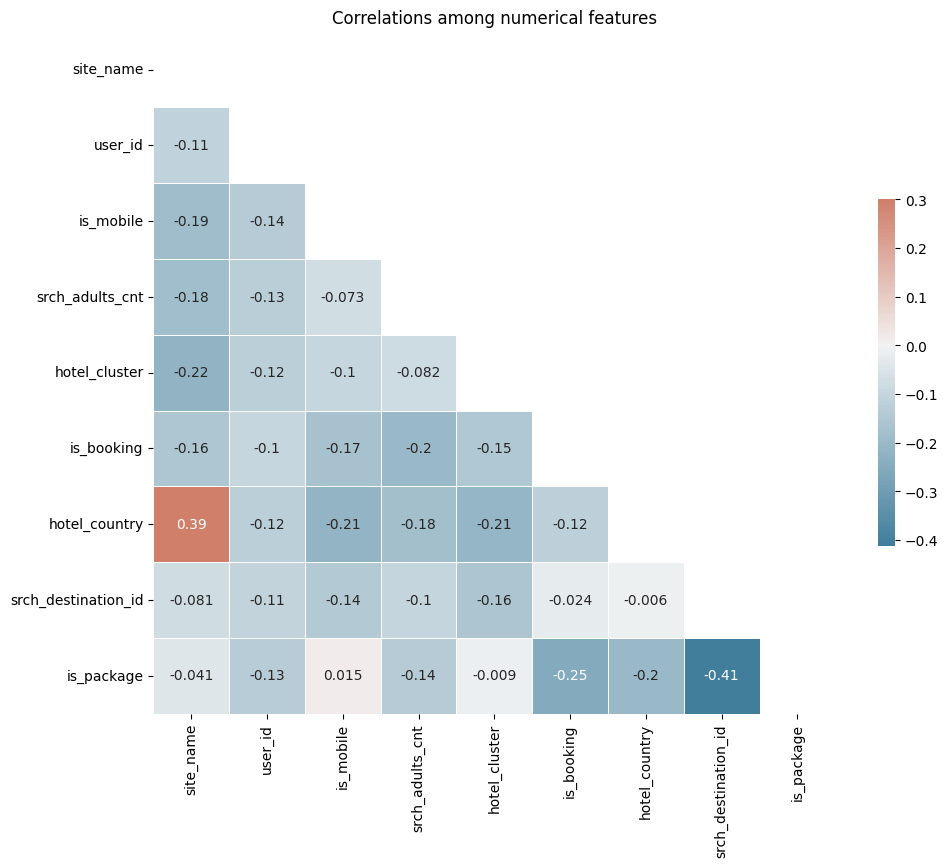

In [28]:
df_plot = pd.DataFrame(data = corr_matrix, index=cols_corr, columns=cols_corr)
plotCorrelationMatrix_1(df_plot, annot=True)
plt.title('Correlations among numerical features')
plt.show()

## Percentage of booking

In [18]:
from pyspark.sql.functions import mean

percent_is_booking = df_hotels.select(mean(df_hotels.is_booking)).collect()[0][0] * 100
print("Porcentagem de reservas por seção:", percent_is_booking)

Porcentagem de reservas por seção: 7.988359712497643


## Percentage of serach with package option

In [19]:
from pyspark.sql.functions import mean

percent_is_package = df_hotels.select(mean(df_hotels.is_package)).collect()[0][0] * 100
print("Porcentagem de reservas por seção:", percent_is_package)

Porcentagem de reservas por seção: 24.78605926881789


## Percentage of searches in Mobile

In [20]:
from pyspark.sql.functions import mean

percent_is_mobile = df_hotels.select(mean(df_hotels.is_mobile)).collect()[0][0] * 100
print("Porcentagem de reservas por seção:", percent_is_mobile)


Porcentagem de reservas por seção: 13.448461724323794


## Percentagem de viajens de users para o mesmo país

In [42]:
same_country_df = df_hotels.filter(df_hotels.user_location_country == df_hotels.hotel_country)
same_country_percentage = (same_country_df.count() / df_hotels.count()) * 100
same_country_percentage

0.13143116591392454

## Média de Filhos e percentagem de filhos ser 0

In [47]:
from pyspark.sql.functions import avg
avg_children_cnt = df_hotels.filter(df_hotels.is_booking == 1).agg(avg(df_hotels.srch_children_cnt)).collect()[0][0]
avg_children_cnt

0.27541048992887057

In [49]:
from pyspark.sql.functions import avg
df_filtered = df_hotels.filter(df_hotels.is_booking == 1)
avg_children_cnt = df_filtered.agg(avg(df_filtered.srch_children_cnt)).collect()[0][0]
pct_avg_children_cnt_zero = df_filtered.filter(df_filtered.srch_children_cnt == 0).count() / df_filtered.count() * 100
pct_avg_children_cnt_zero

81.1540251279665

## Media de pessoas pra reserva

In [52]:
from pyspark.sql.functions import avg
df_filtered = df_hotels.filter(df_hotels.is_booking == 1)
avg_srch_adults_cnt = df_filtered.agg(avg(df_filtered.srch_adults_cnt)).collect()[0][0]
avg_srch_adults_cnt

1.8708036960712624

In [59]:
from pyspark.sql.functions import col

df_filtered = df_hotels.filter(df_hotels.is_booking == 1)
total_rows = df_filtered.count()
filtered_rows = df_filtered.filter(col("srch_adults_cnt") == 1).count()
percentage = (filtered_rows / total_rows) * 100
print("1: ",percentage)
filtered_rows = df_filtered.filter(col("srch_adults_cnt") == 2).count()
percentage = (filtered_rows / total_rows) * 100
print("2: ",percentage)

1:  33.21146047995745
2:  55.720268563451434


# Estatistica sobre pesquisas em que foram efetuadas a reserva

## Foram mais pra fora do país?

In [45]:
same_country_booking_df = df_hotels.filter((df_hotels.user_location_country == df_hotels.hotel_country) & (df_hotels.is_booking == 1))
same_country_booking_percentage = (same_country_booking_df.count() / df_hotels.filter(df_hotels.is_booking == 1).count()) * 100
same_country_booking_percentage

0.12962839859070663

## Percentagem de pesquisas com pelo menos uma criança no mesmo país

In [43]:
same_country_children_df = df_hotels.filter((df_hotels.user_location_country == df_hotels.hotel_country) & (df_hotels.srch_children_cnt == 0))
same_country_children_percentage = (same_country_children_df.count() / df_hotels.count()) * 100
same_country_children_percentage

0.10726907278631416

## Quantas reservas em percentagem são feitas por pacote

In [61]:
from pyspark.sql.functions import col

# calcular a quantidade de linhas em que is_booking == 1 e is_package == 1
num_is_booking_and_is_package = df_hotels.filter((col("is_booking") == 1) & (col("is_package") == 0)).count()

# calcular a quantidade de linhas em que is_booking == 1
num_is_booking = df_hotels.filter(col("is_booking") == 1).count()

# calcular a porcentagem
percentage = (num_is_booking_and_is_package / num_is_booking) * 100

print(f"Percentage of is_package == 1 for is_booking == 1: {percentage:.2f}%")


Percentage of is_package == 1 for is_booking == 1: 86.46%


## Percentagem de Users que viajam para outro país

In [65]:
from pyspark.sql.functions import when, col, sum, count, expr

# filtro para is_booking == 1
df_booking = df_hotels.filter(col('is_booking') == 1)

# criar uma coluna com 1 para quando posa_continent==hotel_continent e 0 para os outros casos
df_booking = df_booking.withColumn('continent_match', when(expr('posa_continent = hotel_continent'), 1).otherwise(0))

# calcular a percentagem de posa_continent==hotel_continent para is_booking == 1
continent_match_pct = df_booking.select((sum(col('continent_match')) / count('*')) * 100).collect()[0][0]

print(f"A percentagem de posa_continent==hotel_continent para is_booking == 1 é {continent_match_pct:.2f}%")


A percentagem de posa_continent==hotel_continent para is_booking == 1 é 5.90%


# Preprocessing

## Create a new column with unique hotels

In [24]:
df_hotels = df_hotels.withColumn('Id_hotel', 
                    F.concat(F.col('hotel_cluster'),F.lit('_'), F.col('hotel_market'),F.lit('_'), F.col('hotel_country'),F.lit('_'), F.col('hotel_continent')))
df_hotels.show(5,vertical = True)


-RECORD 0----------------------------------------
 date_time                 | 2014-06-23 19:34:15 
 site_name                 | 2                   
 posa_continent            | 3                   
 user_location_country     | 66                  
 user_location_region      | 337                 
 user_location_city        | 55714               
 orig_destination_distance | 960.4943            
 is_mobile                 | 0                   
 is_package                | 1                   
 channel                   | 9                   
 srch_ci                   | 2014-08-24 00:00:00 
 srch_co                   | 2014-08-27 00:00:00 
 srch_adults_cnt           | 2                   
 srch_children_cnt         | 1                   
 srch_rm_cnt               | 1                   
 srch_destination_id       | 8268                
 srch_destination_type_id  | 1                   
 is_booking                | 0                   
 cnt                       | 2                   


In [31]:
unique_values = df_hotels.select("Id_hotel").distinct().count()
unique_values

31668

# Feature Engineering

## Create a new column called number of night from time stamp

Create condition if is 1 leave it 1

In [25]:
from pyspark.sql.functions import to_timestamp

df_hotels = df_hotels.withColumn("srch_co", to_timestamp(df_hotels.srch_co, "yyyy-MM-dd HH:mm:ss"))
df_hotels = df_hotels.withColumn("srch_ci", to_timestamp(df_hotels.srch_ci, "yyyy-MM-dd HH:mm:ss"))

from pyspark.sql.functions import datediff
from pyspark.sql.functions import unix_timestamp

#df_hotels = df_hotels.withColumn("num_nights", datediff(df_hotels.srch_co, df_hotels.srch_ci) - 1)
df_hotels = df_hotels.withColumn("num_nights", (unix_timestamp(df_hotels.srch_co) - unix_timestamp(df_hotels.srch_ci)) / 86400 - 1)

In [26]:
df_hotels.show(5, vertical=True)

-RECORD 0----------------------------------------
 date_time                 | 2014-06-23 19:34:15 
 site_name                 | 2                   
 posa_continent            | 3                   
 user_location_country     | 66                  
 user_location_region      | 337                 
 user_location_city        | 55714               
 orig_destination_distance | 960.4943            
 is_mobile                 | 0                   
 is_package                | 1                   
 channel                   | 9                   
 srch_ci                   | 2014-08-24 00:00:00 
 srch_co                   | 2014-08-27 00:00:00 
 srch_adults_cnt           | 2                   
 srch_children_cnt         | 1                   
 srch_rm_cnt               | 1                   
 srch_destination_id       | 8268                
 srch_destination_type_id  | 1                   
 is_booking                | 0                   
 cnt                       | 2                   


In [ ]:
# Correlations

In [ ]:
# Best Viz